### IA_GEOMETRY Functions

In [1]:
%%writefile ia_geometry_func.py
def Cart_to_Sph(xyz): #input np array [[x,y,z]], output[[r,theta,phi]]
    import numpy as np
    ptsnew = np.zeros(xyz.shape)
    xy = xyz[:,0]**2 + xyz[:,1]**2
    ptsnew[:,0] = np.sqrt(xy + xyz[:,2]**2)
    ptsnew[:,1] = np.arctan2(np.sqrt(xy), xyz[:,2]) # for elevation angle defined from Z-axis down
    #ptsnew[:,4] = np.arctan2(xyz[:,2], np.sqrt(xy)) # for elevation angle defined from XY-plane up
    ptsnew[:,2] = np.arctan2(xyz[:,1], xyz[:,0])
    return ptsnew
#pts = np.array([[1,1,1]])
#print(Cart_to_Sph(pts))
#[[r,theta,phi]] = Cart_to_Sph(np.array([[1,1,1]]))
#print(r)#print(theta)#print(phi)

def Cart_to_Polar(xy): #input np array [[x,y]], output[[r,phi]]
    import numpy as np
    ptsnew = np.zeros(xy.shape)
#    ptsnew = np.zeros((1,2))
    ptsnew[:,0] = np.sqrt(xy[:,0]**2+xy[:,1]**2)
    ptsnew[:,1] = np.arctan2(xy[:,1], xy[:,0]) #for elevation angle defined from Z-axis down
    return ptsnew

def Sph_to_Cart(xyz): #input np array [[r,theta,phi]], output[[x,y,z]]
    import numpy as np
    ptsnew = np.zeros(xyz.shape)
#    ptsnew = np.zeros((1,3))
    ptsnew[:,0] = xyz[:,0]*np.sin(xyz[:,1])*np.cos(xyz[:,2])
    ptsnew[:,1] = xyz[:,0]*np.sin(xyz[:,1])*np.sin(xyz[:,2])
    ptsnew[:,2] = xyz[:,0]*np.cos(xyz[:,1])
    return ptsnew
#Cartesian_np(np.array([[1.73205081, 0.95531662, 0.78539816]]))
#pts = np.array([[1,1,1]])
#Cartesian_np(Cart_to_Sph(pts))

def Polar_to_Cart(xy): #input np array [[r,phi]], output[[x,y]]
    import numpy as np
#    ptsnew = np.zeros((1,2))
    ptsnew = np.zeros(xy.shape)
    ptsnew[:,0] = xy[:,0]*np.cos(xy[:,1])
    ptsnew[:,1] = xy[:,0]*np.sin(xy[:,1])
    return ptsnew
#print(Cart_to_Polar(np.array([[-1,0]])))
#np.array([[1,1,1]]).shape

def Ellip_proj_mag(baR_mag,local_theta): # calculates the projected baR ratio
    import numpy as np
    #arctan2 takes (y,x)
    temp = np.arctan(baR_mag/np.tan(local_theta))
    #baR_mag/(np.sin(local_theta)*np.cos(temp)+baR_mag*np.cos(local_theta)*np.sin(temp))
    return baR_mag/(np.sin(local_theta)*np.cos(temp)+baR_mag*np.cos(local_theta)*np.sin(temp))

def Cart_to_eps(sat_state): 
    #input is a length 4 np.array, in cartesian coord, [[sat_location_x, sat_location_y,sat_orient_x,sat_orient_y]], output eps+
    import numpy as np
    sat_state_loc = sat_state[:,0:2] #[sat_location_x, sat_location_y]
    sat_state_orient = sat_state[:,2:4] #[sat_orient_x,sat_orient_y]
    temp_posangle = Cart_to_Polar(sat_state_loc)[:,1][0]
    [[temp_mag,temp_satangle]] = Cart_to_Polar(sat_state_orient)
    #temp_mag = Cart_to_Polar(sat_state_orient)[:,0][0]
    #temp_satangle = Cart_to_Polar(sat_state_orient)[:,1][0]
    return (1-temp_mag**2)/(1+temp_mag**2)*np.cos(2*(temp_satangle-temp_posangle))

def rad_to_deg(rad):
    import numpy as np
    return (rad/np.pi)*180

Overwriting ia_geometry_func.py


In [2]:
%%writefile execution_func.py
def write_file_at_path(path_output, decorated_name, object_name,iteration_tracker):
    import numpy as np
    import os
    #write 'numpy'object_name to file using interation_number as name in path_output/decorated_name/
    fullpath = os.path.join(path_output, decorated_name)
    if not os.path.exists(fullpath):
        os.makedirs(fullpath)
        print('made path', fullpath)
    filename = str(iteration_tracker)
    filename = os.path.join(fullpath, filename)
    file = open(filename, "wb")
    np.save(file, object_name)
    file.close

Overwriting execution_func.py


In [9]:
%%writefile ia_main.py
from mpi4py import MPI
comm = MPI.COMM_WORLD
rank = comm.rank
size = comm.size
import sys
import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
#local modules, no name conflicts
from ia_geometry_func import *
from execution_func import *

###############################################################################################################
########                     This block contains Setups for this simulation                            ########
########                     Scroll to the end of file to code executions                              ########
########                     Check for Rank-Dependence before running                                  ########
###############################################################################################################

def baR_func(x,y,z,global_r,global_theta,global_phi): 
    return baR_0

def theta_func(x,y,z,global_r,global_theta,global_phi,std): 
    #### GAUSSIAN NOISE
    return global_theta+np.random.normal(0,std) #center, std = pi/4 = 0.7853981633974483

def phi_func(x,y,z,global_r,global_theta,global_phi,std): 
    #### GAUSSIAN NOISE
    return global_phi+np.random.normal(0,std)

def density_func(x,y,z,global_r,global_theta,global_phi): #NEED TO BE NORMALIZED
    # this gives the Fraction NUMBER of gals expected in a box of size dV, approximated at (x,y,z)
    # should normalize to 1, but given the finiteness of n,  this only holds as n gets large
    if (x**2+y**2+z**2 > R_cut**2): return 0
    else: return dV/(4*np.pi/3)

def set_condition(n,R_cut,baR_0):
    global dV 
    dV = (2*R_cut)**3/n**3

###############################################################################################################
########                     This block contains the core functions for this simulation                ########
########                               Check for Rank-Dependence before running                        ########
###############################################################################################################

def get_RA_data(save_2D,iteration_tracker,outputpath,n,R_cut,baR_0,phistd,thetastd): 
    #n=50 ~ 6.18 sec without getting All_Sat (best trial)
    #n=100 ~  48.6 sec without getting All_Sat
    #n=200 ~ 7-10 min

    xs = np.linspace(- R_cut, R_cut, n)
    ys = np.linspace(- R_cut, R_cut, n)
    zs = np.linspace(- R_cut, R_cut, n)

    #All_Sats=np.empty((0,7)) #[[x,y,z,xlocal,ylocal,zlocal,numberfraction]]
    All_Sats_2D=np.empty((0,5))  #[[x,y,average_xlocal, average_ylocal,numberfraction]]
    All_Sats_2D_eps=np.empty((0,4))  #[[x,y,eps+,numberfraction]]
    for x in xs:
        #print(x)
        for y in ys:
            temp_baR_num = np.empty((0,3)) 
            # this stores the data point with the same x,y but different z coord, and store [[localx*num,localy*num,num(i.e. frac density)],...]
            for z in zs:
                [[global_r,global_theta,global_phi]] = Cart_to_Sph(np.array([[x,y,z]]))   #get sat's position in global sph coord

                local_density = density_func(x,y,z,global_r,global_theta,global_phi)
                local_baR = baR_func(x,y,z,global_r,global_theta,global_phi)
                local_theta = theta_func(x,y,z,global_r,global_theta,global_phi,thetastd)
                local_phi = phi_func(x,y,z,global_r,global_theta,global_phi,phistd)

                local_baR_vector = np.array([[local_baR,local_theta,local_phi]]) #get sat's orientation in local sph coord
                [[local_x,local_y,local_z]] = Sph_to_Cart(local_baR_vector) #get sat's orientation in local Cart coord

                #build 3D catalogue
    #            All_Sats = np.append(All_Sats,[[x, #sat's location
    #                                            y,  #sat's location
    #                                            z,  #sat's location
    #                                            local_x,  #sat's baR mag and orient
    #                                            local_y,  #sat's baR mag and orient
    #                                            local_z,  #sat's baR mag and orient
    #                                            local_density #approximated frac of sats in dV around (x,y,z)
    #                                            ]],axis=0)

                #build 2D projected catalogue with average baR
                proj_mag = Ellip_proj_mag(local_baR,local_theta)    #calculate the projected b/a Ratio first
                [[proj_local_x, proj_local_y]]=Polar_to_Cart(np.array([[proj_mag,local_phi]]))    #convert the projected vector to cartesian

                temp_baR_num = np.append(temp_baR_num,[[proj_local_x*local_density,proj_local_y*local_density,local_density]],axis=0)

            #compute the average baR vector
            sum_temp = np.sum(temp_baR_num,axis=0)

            if (np.abs(sum_temp[2])) >= 10.**(-13):# if the density is 0, can just set the mean vector to 0, this also avoids 0 division
                [mean_temp_x,mean_temp_y] = sum_temp[0:2]/sum_temp[2]
                All_Sats_2D = np.append(All_Sats_2D,[[x,y,mean_temp_x,mean_temp_y,sum_temp[2]]],axis=0)

                #from the average baR vector, compute the expected eps+ value at (x,y)
                All_Sats_2D_eps = np.append(All_Sats_2D_eps,np.array([[
                                                                        x,
                                                                        y,
                                                                        Cart_to_eps(np.array([[x,y,mean_temp_x,mean_temp_y]])),
                                                                        sum_temp[2]
                                                                        ]]),axis=0)
    #Now perform radial averaging and get the gamma+ function
    n_radial = int(n)
    rs = np.linspace(0, R_cut, n_radial)
    gamma_plus = np.zeros(rs.shape)
    for i in range(len(rs)):
        count=0
        for elmt in All_Sats_2D_eps:
            # if in the radial interval of 0 and 0.001(lets say e.g.).., and so on
            if (np.sqrt(elmt[0]**2+elmt[1]**2) >= rs[i] and np.sqrt(elmt[0]**2+elmt[1]**2) < rs[i]+R_cut/(n_radial-1)):
                count += elmt[3]
                gamma_plus[i] += elmt[2]*elmt[3]
        if (count == 0):
            #print(count)
            #print(gamma_plus[i])
            gamma_plus[i]=0
        else: gamma_plus[i]=gamma_plus[i]/count
    
    if save_2D == True:
        write_file_at_path(outputpath, 'All_Sats_2D smr=%1.3f'%smr, All_Sats_2D,iteration_tracker)
        write_file_at_path(outputpath, 'All_Sats_2D_eps smr=%1.3f'%smr, All_Sats_2D_eps,iteration_tracker)
        write_file_at_path(outputpath, 'Gamma_plus smr=%1.3f'%smr, gamma_plus,iteration_tracker)
        print("finished saving 2D, 2D_EPS, and Gamma_plus")

def Plot_Gamma_Plus(n,smoothing_len,baR_0, outputpath,searchpath,imagename):
    #smoothing length (multiples of 2): plotting one datapoint for every smoothing length worth of eps data (taking arithmetic average ), >=2
    #output path is where the figure folder is saved
    #searchpath is where all the gamma_plus data are stored
    rs = np.linspace(0, R_cut, int(n/smoothing_len))
        
    #read all the file names in the searchpath folder
    filenames = [f for f in os.listdir(searchpath) if os.path.isfile(os.path.join(searchpath, f))]
    print('file names discovered',filenames)
    
    fig= plt.figure(figsize=(9,6))
    #Plotting gamma curves
    for filename in filenames:
        filepath = os.path.join(searchpath, filename)
        file = open(filepath, "rb")
        gammapls_temp = np.load(file)
        file.close
        
        smoothed_gamma = [sum(gammapls_temp[i:i+smoothing_len])/smoothing_len for i in range(0,len(gammapls_temp),smoothing_len)]
        #print(smoothed_gamma)
        #print(gammapls_temp)
        #print(len(smoothed_gamma))
        plt.plot(rs,smoothed_gamma,label=filename)
    
    #Plotting reference curves
    asymp = np.array([])
    y_0 = np.zeros(rs.shape)
    for r in rs:
        asymp = np.append(asymp,(1-(baR_0)**2)/(1+(baR_0)**2))

    plt.plot(rs,y_0,label='y=0')
    plt.plot(rs,asymp,"--",label=(
        "asymptotic value %1.3f, b/a_0 = %1.2f" %(
            float((1-(baR_0)**2)/(1+(baR_0)**2)), baR_0)))

    plt.xlabel('distance')
    plt.ylabel('gamma +')
    plt.title('gamma + vs. normalized distance from cluster center')
    plt.xlim(0,0.9)
    plt.ylim(-1,1)
    plt.legend(bbox_to_anchor=(1, 1), loc='upper left', ncol=1)
    #plt.show()
    imagesavepath = os.path.join(outputpath, 'figures')
    if not os.path.exists(imagesavepath):
        os.makedirs(imagesavepath)
    fig.savefig(os.path.join(imagesavepath, imagename), bbox_inches = 'tight')

###############################################################################################################
########                     Execution code happens below                                              ########
###############################################################################################################

n=50
R_cut = 1.0
baR_0 = 0.2
set_condition(n,R_cut,baR_0)

sim_step = 6

if rank == 0:
    for index in range(sim_step):
        smr=rank*np.pi/8
        print('rank ',rank,':  on task ',index+1)
        #smr=(np.pi)/8*index
        #print(smr)
        outputpath = '/home/azhou/IA-Sim-AZhou00/IA_Numeric_Output/n%i-baR_0%1.1f-phiSTD%1.2f-thetaSTD%1.2f' %(n,baR_0,rad_to_deg(smr),rad_to_deg(smr))
        get_RA_data(True,index,outputpath,n,R_cut,baR_0,smr,smr)
        print('rank ',rank,': ',index+1,' out of ',sim_step,' done')
    
    searchpath = os.path.join(outputpath,'Gamma_plus smr=%1.3f'%smr)
    Plot_Gamma_Plus(n,2,baR_0,outputpath,searchpath,'Gamma_Plus_baR=2e-1_smearing,smoothing=2')

if rank == 1:
    smr=rank*np.pi/8
    for index in range(sim_step):
        print('rank ',rank,':  on task ',index+1)
        #smr=(np.pi)/8*index
        #print(smr)
        outputpath = '/home/azhou/IA-Sim-AZhou00/IA_Numeric_Output/n%i-baR_0%1.1f-phiSTD%1.2f-thetaSTD%1.2f' %(n,baR_0,rad_to_deg(smr),rad_to_deg(smr))
        get_RA_data(True,index,outputpath,n,R_cut,baR_0,smr,smr)
        print('rank ',rank,': ',index+1,' out of ',sim_step,' done')
    
    searchpath = os.path.join(outputpath,'Gamma_plus smr=%1.3f'%smr)
    Plot_Gamma_Plus(n,2,baR_0,outputpath,searchpath,'Gamma_Plus_baR=2e-1_smearing,smoothing=2')

if rank == 2:
    smr=rank*np.pi/8
    for index in range(sim_step):
        print('rank ',rank,':  on task ',index+1)
        #smr=(np.pi)/8*index
        #print(smr)
        outputpath = '/home/azhou/IA-Sim-AZhou00/IA_Numeric_Output/n%i-baR_0%1.1f-phiSTD%1.2f-thetaSTD%1.2f' %(n,baR_0,rad_to_deg(smr),rad_to_deg(smr))
        get_RA_data(True,index,outputpath,n,R_cut,baR_0,smr,smr)
        print('rank ',rank,': ',index+1,' out of ',sim_step,' done')
    
    searchpath = os.path.join(outputpath,'Gamma_plus smr=%1.3f'%smr)
    Plot_Gamma_Plus(n,2,baR_0,outputpath,searchpath,'Gamma_Plus_baR=2e-1_smearing,smoothing=2')


Overwriting ia_main.py


### Setting Functions

file names discovered ['0', '1', '2']


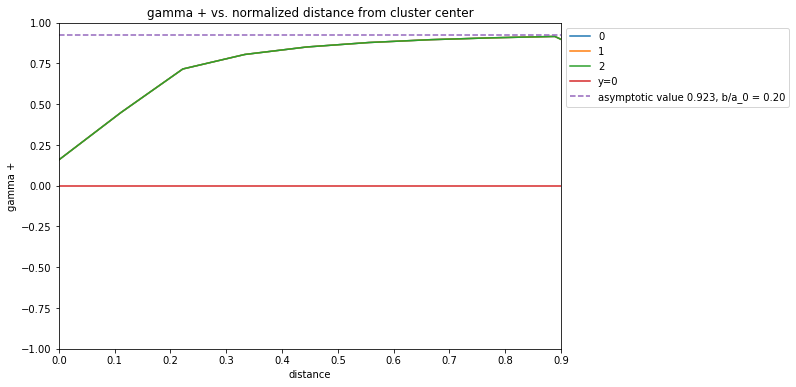

In [15]:
#for index in range(sim_step):
#    smr=0
#    #smr=(np.pi)/8*index
#    #print(smr)
outputpath = '/home/azhou/IA-Sim-AZhou00/IA_Numeric_Output/n%i-baR_0%1.1f-phiSTD%1.2f-thetaSTD%1.2f' %(n,baR_0,rad_to_deg(smr),rad_to_deg(smr))
searchpath = os.path.join(outputpath,'Gamma_plus smr=%1.3f'%smr)
Plot_Gamma_Plus(n,5,baR_0,outputpath,searchpath,'Gamma_Plus_baR=2e-1_smearing,smoothing=5')

In [1]:
def test():
    return baR_0

In [2]:
test()

NameError: name 'baR_0' is not defined

In [4]:
baR_0 = 2
print(test())
baR_0 = 3
print(test())

2
3
